# Seizure detection sandbox

## Workspace Preparation

In [1]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler

# Data IO imports
import mne
import mne_bids
from mne_bids import BIDSPath, read_raw_bids

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for machine learning
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV

# Imports for deep learning
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')


In [2]:
plt.rcParams['image.cmap'] = 'magma'

In [3]:
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
passpath = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
prodatapath = CONFIG["paths"]["PROCESSED_DATA"]
figpath = CONFIG["paths"]["FIGURES"]
patient_table = pd.DataFrame(CONFIG["patients"]).sort_values('ptID')
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = patient_table.ptID.to_numpy()

In [5]:
temp = pd.read_pickle(ospj(prodatapath,"HUP257","probability_matrix_mdl-LSTM_fs-256_montage-bipolar_task-ictal387681_run-01.pkl"))

In [6]:
temp.head()

,RA01-RA02,RA02-RA03,RA03-RA04,RA04-RA05,RA05-RA06,RA06-RA07,RA07-RA08,RA08-RA09,RA09-RA10,RA10-RA11,...,RY03-RY04,RY04-RY05,RY05-RY06,RY06-RY07,RY07-RY08,RY08-RY09,RY09-RY10,RY10-RY11,RY11-RY12,time
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,1.5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,2.0


In [4]:
set_seed(5210)

In [5]:
pt = 'HUP238'
montage = 'bipolar'
inter_times = {"HUP235": 307651,
               "HUP238": 100011,
               "HUP246": 100000}

In [6]:
all_seizure_times = pd.read_csv(ospj(prodatapath,"consensus_annots.csv"))
seizure_times = all_seizure_times[all_seizure_times.patient == pt]
seizure_times.head()

,Seizure_ID,clinician,patient,eec,eec_time,ueo,ueo_time,sec,spread,all_chs,iEEG_ID,offset,stim,eec_consensus,eec_time_consensus,ueo_consensus,ueo_time_consensus,sec_consensus
4,HUP238_1,"['CK', 'DZ', 'EC', 'JJ', 'JK']",HUP238,"[[False, False, False, True, False, False, Fal...","[10653.02, 10653.16, 10641.25, 10653.04, 10641...","[[False, False, False, False, False, False, Fa...","[10653.02, 10653.16, 10652.98, 10653.04, 10653...","[[False, False, False, True, False, False, Fal...","[[False, False, False, True, False, False, Fal...","['F04', 'F08', 'Fp02', 'LA01', 'LA02', 'LA03',...",HUP238_phaseII,10792.34,1.0,[False False False True False False False Fal...,10653.02,[False False False False False False False Fal...,10653.04,[False False False True False False False Fal...
5,HUP238_2,"['CK', 'DZ', 'EC', 'JJ', 'JK']",HUP238,"[[False, False, False, True, True, True, False...","[290006.9, 290008.61, 290006.97, 290006.93, 29...","[[False, False, False, False, False, False, Fa...","[290008.46, 290008.61, 290009.78, 290008.61, 2...","[[False, False, False, True, True, False, Fals...","[[False, False, False, True, False, False, Fal...","['F04', 'F08', 'Fp02', 'LA01', 'LA02', 'LA03',...",HUP238_phaseII,290152.56,0.0,[False False False True True True False Fal...,290006.94,[False False False False False False False Fal...,290008.61,[False False False True True True False Fal...
6,HUP238_3,"['CK', 'DZ', 'EC', 'JJ', 'JK']",HUP238,"[[False, False, False, False, False, False, Fa...","[412269.46, 412268.16, 412269.46, 412268.16, 4...","[[False, False, False, False, False, False, Fa...","[412269.46, 412269.46, 412269.46, 412269.29, 4...","[[False, False, False, False, False, False, Fa...","[[False, False, False, False, False, False, Fa...","['F04', 'F08', 'Fp02', 'LA01', 'LA02', 'LA03',...",HUP238_phaseII,412383.25,0.0,[False False False False False False False Fal...,412268.83,[False False False False False False False Fal...,412269.46,[False False False False False False False Fal...
7,HUP238_4,"['CK', 'DZ', 'EC', 'JJ', 'JK']",HUP238,"[[False, False, False, True, True, True, False...","[465564.53, 465564.79, 465564.79, 465564.75, 4...","[[False, False, False, False, False, False, Fa...","[465566.01, 465565.78, 465566.05, 465566.04, 4...","[[False, False, False, True, False, False, Fal...","[[False, False, False, False, False, False, Fa...","['F04', 'F08', 'Fp02', 'LA01', 'LA02', 'LA03',...",HUP238_phaseII,465680.72,0.0,[False False False True True True False Fal...,465564.76,[False False False False False False False Fal...,465566.04,[False False False True True True False Fal...


## Defining Model Architectures

## Pulling Ictal Data

In [7]:
 # Defining paths for saved data
raw_datapath = ospj(datapath,pt)
if not os.path.exists(ospj(raw_datapath, "seizures")):
    os.mkdir(ospj(raw_datapath, "seizures"))

In [8]:
# access iEEG
with open('woj_ieeglogin.bin', 'r') as f:
  session = Session('wojemann', f.read())
ds = session.open_dataset(f'{pt}_phaseII')
# get labels and time series info
raw_labels = clean_labels(ds.get_channel_labels(),pt)
# chn_labels = [l for l in raw_labels if l not in ['Cz','Fz','C03','C04','F04','F08','Fp02','O01','P04','T04','T06','EKG01','EKG02','ROC','LOC']]
chn_labels = remove_scalp_electrodes(raw_labels)
timeseries = ds.get_time_series_details(chn_labels[0])

#get the sampling frequency
fs = timeseries.sample_rate

IeegConnectionError: 

### Code for saving and preprocessing

In [ ]:
# def preprocess_presave(data,fs,montage='bipolar',factor=4):
#     chs = data.columns.to_list()
#     ch_df = check_channel_types(chs)
#     # Montage
#     if montage == 'bipolar':
#         data_bp_np,bp_ch_df = bipolar_montage(data.to_numpy().T,ch_df)
#         bp_ch = bp_ch_df.name.to_numpy()
#     elif montage == 'car':
#         data_bp_np = (data.to_numpy().T - np.mean(data.to_numpy(),1))
#         bp_ch = chs
#     # Bandpass filtering
#     b,a = sc.signal.butter(4,[3,58],btype='bandpass',fs = fs)
#     data_bp_filt = sc.signal.filtfilt(b,a,data_bp_np,axis=1)
#     # Down sampling
#     data_bpd = sc.signal.decimate(data_bp_filt,factor).T
#     fsd = fs/factor
#     data_white = ar_one(data_bpd)
#     data_white_df = pd.DataFrame(data_white,columns = bp_ch)
#     return data_white_df,fsd

In [ ]:
# for _,row in seizure_times.iterrows():
#     i_sz = int(float(row.Seizure_ID[7:]))
#     print(f"Saving seizure number: {i_sz}")
#     seizure,fs = get_iEEG_data(usr,passpath,
#                                 row.iEEG_ID,
#                                 (row.ueo_time_consensus-60)*1e6,
#                                 (row.offset+60)*1e6,
#                                 chn_labels,
#                                 force_pull = True)
#     seizure_prep,fsd = preprocess_presave(seizure,fs)
#     seizure_prep.to_pickle(ospj(raw_datapath,"seizures",f"det{int(fsd)}_seizure_{i_sz}_stim_{int(row.stim)}_{montage}.pkl"))

## Training Unsupervised Models

### Code for BIDS IO

In [33]:
all_subjects = mne_bids.get_entity_vals(ospj(datapath,'BIDS'),'subject')
ignore_subjects = [s for s in all_subjects if s != 'HUP235']
tasks = mne_bids.get_entity_vals(ospj(datapath,'BIDS'), 'task', ignore_subjects=ignore_subjects)
training_file = [t for t in tasks if 'interictal' in t][0]
ignore_tasks = [t for t in tasks if t != training_file]
run = mne_bids.get_entity_vals(ospj(datapath,'BIDS'), 'run', 
                               ignore_tasks = ignore_tasks,
                               ignore_subjects=ignore_subjects)[0]
training_file


'interictal307651'

In [37]:
bidspath = BIDSPath(root=ospj(datapath,"BIDS"),subject='HUP235',task=training_file,run=run,session='clinical01')

In [38]:
training_raw = read_raw_bids(bidspath)

Extracting EDF parameters from /mnt/leif/littlab/users/wojemann/stim-seizures/RAW_DATA/BIDS/sub-HUP235/ses-clinical01/ieeg/sub-HUP235_ses-clinical01_task-interictal307651_run-00_ieeg.edf...
EDF file detected


Setting channel info structure...
Creating raw.info structure...
Reading events from /mnt/leif/littlab/users/wojemann/stim-seizures/RAW_DATA/BIDS/sub-HUP235/ses-clinical01/ieeg/sub-HUP235_ses-clinical01_task-interictal307651_run-00_events.tsv.
Reading channel info from /mnt/leif/littlab/users/wojemann/stim-seizures/RAW_DATA/BIDS/sub-HUP235/ses-clinical01/ieeg/sub-HUP235_ses-clinical01_task-interictal307651_run-00_channels.tsv.


In [39]:
training_df = training_raw.to_data_frame()
training_df.head()

,time,C03,C04,Cz,EKG01,EKG02,Fz,LA01,LA02,LA03,...,LZ04,LZ05,LZ06,LZ07,LZ08,LZ09,LZ10,LZ11,LZ12,ROC
0,0.000000,52.103308,51.039088,53.962681,176.823631,135.591163,27.112206,-0.259969,-0.123337,-0.069134,...,0.033747,0.042530,0.022053,0.022324,0.020449,0.067769,-0.004543,0.004783,0.022595,0.037472
1,0.001953,48.645596,49.444765,51.569190,173.083832,97.341067,24.453664,-0.261030,-0.124398,-0.067530,...,0.035622,0.045713,0.028443,0.030293,0.026296,0.072037,0.001847,0.009026,0.026049,0.030836
2,0.003906,53.167528,53.962681,58.215546,172.279065,71.257152,29.770749,-0.261572,-0.123337,-0.066469,...,0.037472,0.049438,0.034290,0.034018,0.033476,0.076281,0.013541,0.014355,0.029232,0.038262
3,0.005859,48.910647,48.380545,52.103308,189.557884,95.210801,24.188613,-0.269813,-0.128395,-0.072316,...,0.034537,0.044109,0.030564,0.034018,0.029232,0.074949,0.015663,0.012751,0.027628,0.031354
4,0.007812,46.252105,46.521172,46.786223,179.995360,106.619556,21.530071,-0.275389,-0.135032,-0.077103,...,0.030836,0.041198,0.028689,0.033747,0.027357,0.074677,0.015416,0.009569,0.025235,0.029750


In [43]:
1/training_df.time.diff().mode().item()

512.0

In [45]:
training_df.drop('time',axis=1)

,C03,C04,Cz,EKG01,EKG02,Fz,LA01,LA02,LA03,LA04,...,LZ04,LZ05,LZ06,LZ07,LZ08,LZ09,LZ10,LZ11,LZ12,ROC
0,52.103308,51.039088,53.962681,176.823631,135.591163,27.112206,-0.259969,-0.123337,-0.069134,-0.005851,...,0.033747,0.042530,0.022053,0.022324,0.020449,0.067769,-0.004543,0.004783,0.022595,0.037472
1,48.645596,49.444765,51.569190,173.083832,97.341067,24.453664,-0.261030,-0.124398,-0.067530,-0.005061,...,0.035622,0.045713,0.028443,0.030293,0.026296,0.072037,0.001847,0.009026,0.026049,0.030836
2,53.167528,53.962681,58.215546,172.279065,71.257152,29.770749,-0.261572,-0.123337,-0.066469,-0.004272,...,0.037472,0.049438,0.034290,0.034018,0.033476,0.076281,0.013541,0.014355,0.029232,0.038262
3,48.910647,48.380545,52.103308,189.557884,95.210801,24.188613,-0.269813,-0.128395,-0.072316,-0.012512,...,0.034537,0.044109,0.030564,0.034018,0.029232,0.074949,0.015663,0.012751,0.027628,0.031354
4,46.252105,46.521172,46.786223,179.995360,106.619556,21.530071,-0.275389,-0.135032,-0.077103,-0.019938,...,0.030836,0.041198,0.028689,0.033747,0.027357,0.074677,0.015416,0.009569,0.025235,0.029750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,17.277206,19.405646,1.325952,-99.637463,-85.056981,-14.890353,-0.200165,-0.134242,-0.113789,-0.062744,...,-0.003211,0.009569,-0.025268,-0.032718,-0.049717,-0.077103,-0.173322,-0.129974,-0.010909,0.073888
10236,14.883715,18.076375,1.860070,-96.181699,-110.288789,-15.950558,-0.195650,-0.132910,-0.112186,-0.061411,...,-0.001336,0.013541,-0.019938,-0.026871,-0.042538,-0.070466,-0.167475,-0.125459,-0.009848,0.069644
10237,16.482053,19.136579,4.783663,-81.601217,-105.223492,-13.026964,-0.194318,-0.134242,-0.112186,-0.061411,...,0.001575,0.015663,-0.015424,-0.021271,-0.037505,-0.064347,-0.162417,-0.122005,-0.007997,0.069101
10238,20.999969,25.252833,8.771477,-116.158854,-138.455630,-6.914726,-0.192714,-0.131035,-0.109003,-0.061954,...,0.005029,0.019388,-0.010391,-0.013302,-0.031904,-0.057957,-0.157088,-0.117219,-0.006665,0.073370


### Code for saving and preprocessing

In [11]:
# print(f"Saving interictal training data")
# INTERTIME = inter_times[pt]
# pt_ieeg = f'{pt}_phaseII'
# inter,fs = get_iEEG_data(usr,passpath,
#                             row.iEEG_ID,
#                             INTERTIME*1e6,
#                             (INTERTIME+10)*1e6,
#                             chn_labels,
#                             force_pull = True)

# inter_prep,fsd = preprocess_presave(inter,fs)
# inter_prep.to_pickle(ospj(raw_datapath,"seizures",f"det{int(fsd)}_interictal_{montage}.pkl"))

### Code for data formatting and training

#### data formatting

In [12]:
def prepare_segment(data, fs = 256,train_win = 12, pred_win = 1, w_size = 1, w_stride=0.5,ret_time=False):
    data_ch = data.columns.to_list()
    data_np = data.to_numpy()
    train_win = 12
    pred_win = 1
    j = fs-(train_win+pred_win)+1
    nwins = num_wins(len(data),fs,w_size,w_stride)
    data_mat = torch.zeros((nwins,j,(train_win+pred_win),len(data_ch)))
    for k in range(len(data_ch)): # Iterating through channels
        samples = MovingWinClips(data_np[:,k],fs,1,0.5)
        for i in range(samples.shape[0]):
            clip = samples[i,:]
            mat = torch.tensor(hankel(clip[:j],clip[-(train_win+pred_win):]))
            data_mat[i,:,:,k] = mat
    time_mat = MovingWinClips(np.arange(len(data))/fs,fs,1,0.5)
    win_times = time_mat[:,0]
    data_flat = data_mat.reshape((-1,train_win + pred_win,len(data_ch)))
    input_data = data_flat[:,:-1,:].float()
    target_data = data_flat[:,-1,:].float()
    if ret_time:
        return input_data, target_data, win_times
    else:
        return input_data, target_data

In [13]:
def predict_sz(model, input_data, target_data,batch_size=1):
    dataset = TensorDataset(input_data,target_data)
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=False)
    ccheck = torch.cuda.is_available()
    if ccheck:
        model.cuda()
    with torch.no_grad():
        model.eval()
        mse_distribution = []
        for inputs, targets in tqdm(dataloader):
            if ccheck:
                inputs = inputs.cuda()
                targets = targets.cuda()
            outputs = model(inputs)
            mse = (outputs-targets)**2
            mse_distribution.append(mse)
    return torch.cat(mse_distribution).cpu().numpy()

In [14]:
def repair_data(outputs,data,fs=256,train_win=12,pred_win=1,w_size=1,w_stride=.5):
    nwins = num_wins(len(data),fs,w_size,w_stride)
    nchannels = data.shape[1]
    repaired = outputs.reshape((nwins,fs-(train_win + pred_win)+1,nchannels))
    return repaired

#### preparing training

In [15]:
fs = 256
inter = pd.read_pickle(ospj(raw_datapath,"seizures",f"det{fs}_interictal_{montage}.pkl"))

In [16]:
# Prepare input and target data for the LSTM
input_data,target_data = prepare_segment(inter)

dataset = TensorDataset(input_data, target_data)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)

# Instantiate the model
input_size = input_data.shape[2]
hidden_size = 10
output_size = input_data.shape[2]

In [17]:
input_data.shape

torch.Size([4392, 12, 116])

In [89]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1,:])
        return out
    
class LSTMX(nn.Module):
    def __init__(self, num_channels, hidden_size):
        super(LSTMX, self).__init__()
        self.num_channels = num_channels
        self.lstms = nn.ModuleList([nn.LSTM(1, hidden_size, batch_first=True) for _ in range(num_channels)])
        self.fcs = nn.ModuleList([nn.Linear(hidden_size, 1) for _ in range(num_channels)])

    def forward(self, x):
        outputs = []
        for i in range(self.num_channels):
            out, _ = self.lstms[i](x[:, :, i].unsqueeze(-1))  # LSTM input shape: (batch_size, seq_len, 1)
            out = self.fcs[i](out[:, -1, :])  # FC input shape: (batch_size, hidden_size)
            outputs.append(out.unsqueeze(1))  # Add channel dimension back

        # Concatenate outputs along channel dimension
        output = torch.cat(outputs, dim=1).squeeze()  # shape: (batch_size, num_channels, 1)
        return output

    
class LRModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LRModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Flatten the input along the 'sequence length' dimension
        x = x.squeeze()
        out = self.linear(x)
        return out


#### model initialization and training

In [97]:
# Initialize the model
# model = LSTMX(input_size, hidden_size)
model = LSTMModel(input_size,hidden_size,output_size)
print(model)
ccheck = torch.cuda.is_available()
if ccheck:
   model.cuda()
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

LSTMModel(
  (lstm): LSTM(116, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=116, bias=True)
)


In [98]:
# Training loop
num_epochs = 100
loss_checkpoint = np.inf
brake_check=False
for epoch in range(num_epochs):
    running_loss = 0
    for inputs, targets in dataloader:
        if ccheck:
            inputs = inputs.cuda()
            targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 9:
        running_loss /= len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        
        if running_loss < loss_checkpoint:
            loss_checkpoint = running_loss
        else:
            brake_check = True
            break
    if brake_check:
        break

Epoch [10/100], Loss: 59.1389
Epoch [20/100], Loss: 52.8421
Epoch [30/100], Loss: 48.9958
Epoch [40/100], Loss: 47.0130
Epoch [50/100], Loss: 46.2849
Epoch [60/100], Loss: 45.1216
Epoch [70/100], Loss: 44.5073
Epoch [80/100], Loss: 44.3612
Epoch [90/100], Loss: 43.8050
Epoch [100/100], Loss: 43.5915


#### determining detection threshold

In [99]:
input_data,target_data = prepare_segment(inter)
inter_outputs = predict_sz(model,input_data,target_data,batch_size=400)
thresholds = np.percentile(inter_outputs,95,0)

100%|██████████| 11/11 [00:00<00:00, 156.07it/s]


### One class classifier

In [100]:
inter_training_mat = repair_data(inter_outputs,inter)
post_model = svm.OneClassSVM()
model_array = [svm.OneClassSVM() for _ in range(inter_training_mat.shape[2])]
for i,m in enumerate(model_array):
    x_train = np.percentile(inter_training_mat[:,:,i],axis=1,q = 85).reshape(-1,1)
    m.fit(x_train)
    # m.intercept_ *= -1
    # m_cal = CalibratedClassifierCV(m, method='sigmoid')
    # m_cal.fit(x_train, [1] * len(inter_training_mat))
    # m_cal.intercept_ *= -1


## Seizure Detection

### Generating probability heatmaps

In [101]:
def scale_normalized(data,m=5):
    # takes in data and returns a flattened array with outliers removed based on distribution of entire tensor
    data_flat = data.flatten()
    d = np.abs(data_flat - np.median(data_flat))
    mdev = np.median(d)
    s = d / mdev
    scaler = np.max(data_flat[s<m])
    data_norm = data/scaler
    data_norm[data_norm > 1] = 1
    return data_norm

In [102]:
seizure = pd.read_pickle(ospj(raw_datapath,"seizures",f"det{int(256)}_seizure_{2}_stim_{0}_{montage}.pkl"))

In [103]:
mask,info = detect_bad_channels(seizure.to_numpy(),fs)

In [104]:
train_win = 12
pred_win = 1
input_data, target_data, win_times = prepare_segment(seizure,fs,train_win,pred_win,ret_time=True)

In [105]:
outputs = predict_sz(model,input_data,target_data,400)
seizure_mat = repair_data(outputs,seizure)

100%|██████████| 321/321 [00:02<00:00, 134.69it/s]


In [106]:
# Getting raw predicted loss values for each window
raw_sz_vals = np.mean(np.log(seizure_mat),1).T
# Creating classifications
sz_clf = (raw_sz_vals.T > np.log(thresholds)).T
# Dropping channels with too many positive detections (bad channels)
# This should be replaced with actual channel rejection
rejection_mask = np.sum(sz_clf[:,:120],axis=1) > 80#(sz_clf.shape[1]*3/5)
sz_clf[rejection_mask,:] = 0 # fake channel rejection
sz_clf[~mask,:] = 0 # real channel rejection

# Normalizing values of the loss
norm_sz_vals = scale_normalized(np.mean(np.log(seizure_mat),1).T)
# Creating smoothed sz values
sz_vals = sc.ndimage.uniform_filter1d(raw_sz_vals,10,axis=1)
# Creating probabilities by temporally smoothing classification
sz_prob = sc.ndimage.uniform_filter1d(sz_clf.astype(float),10,axis=1)
# Sorting channels based on probability at sz onset
first_detect = np.argmax(sz_prob[:,115:]>.5,axis=1)
first_detect[first_detect == 0] = sz_prob.shape[1]
ch_sorting = np.argsort(first_detect)

# rejecting noisy/late channels
bottom_mask = np.sum(sz_clf[ch_sorting,:],axis=1) > 0
first_zero = np.where(~bottom_mask)[0][0].astype(int)
sz_clf[ch_sorting[first_zero:],:] = 0
sz_prob[ch_sorting[first_zero:],:] = 0
# sz_vals[ch_sorting[first_zero:],:] = 0

### Plotting seizure detection pipeline

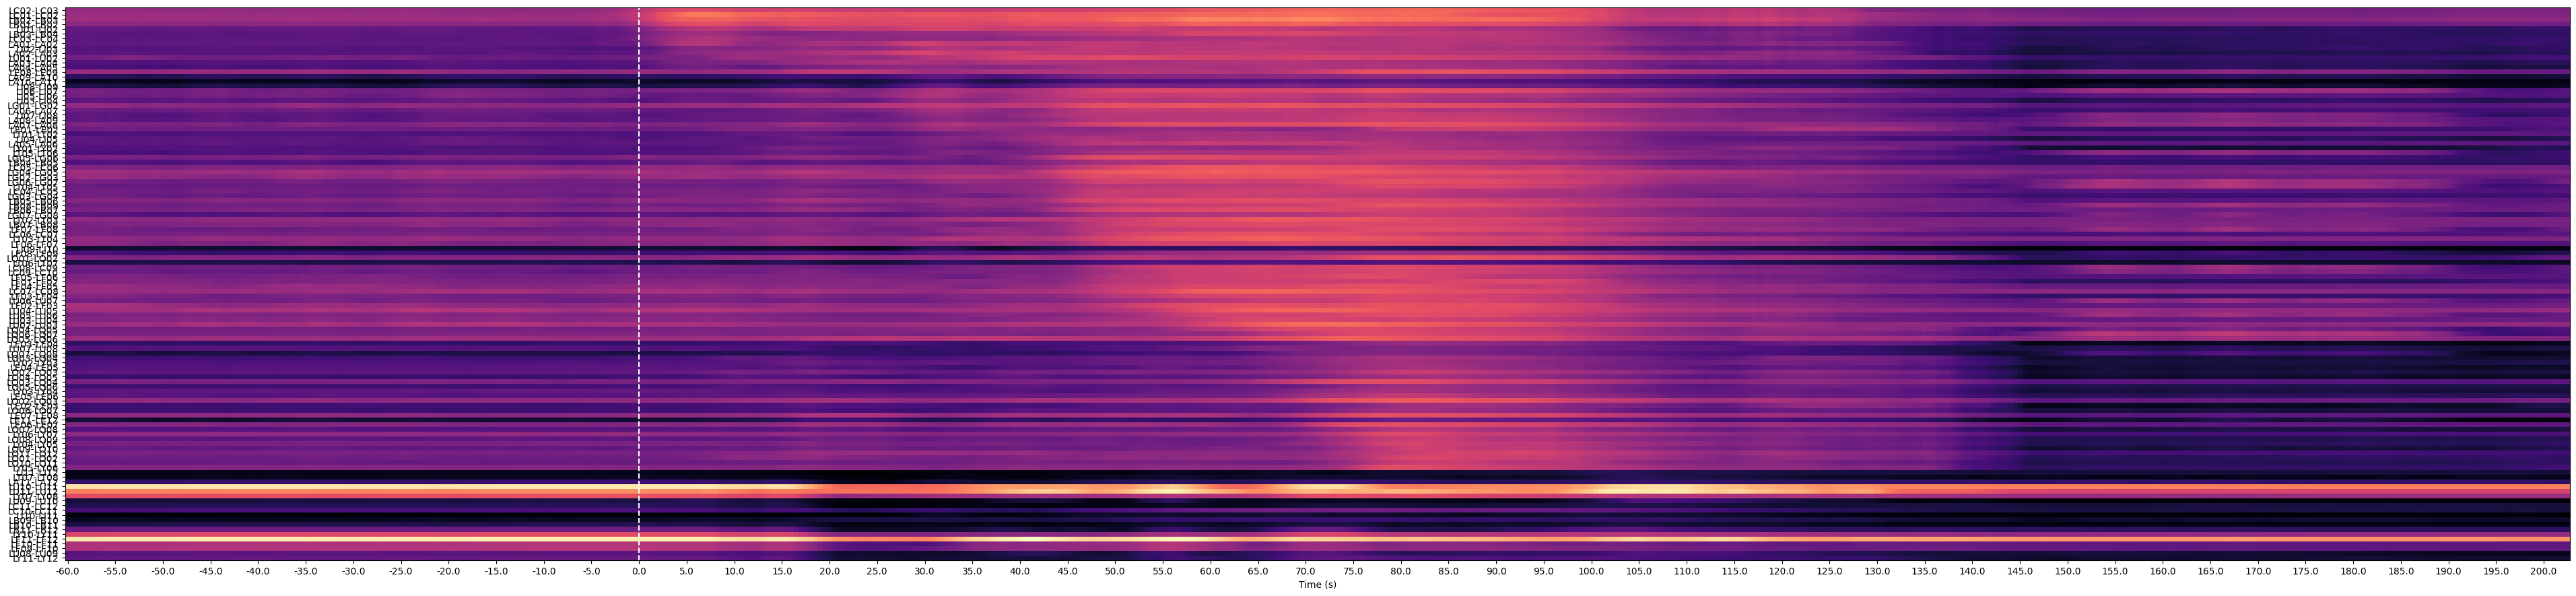

In [107]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_vals[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)] - 60)
# plt.colorbar()
# plt.xlim([115,400])
plt.savefig(ospj(figpath,'sample_vals.png'))

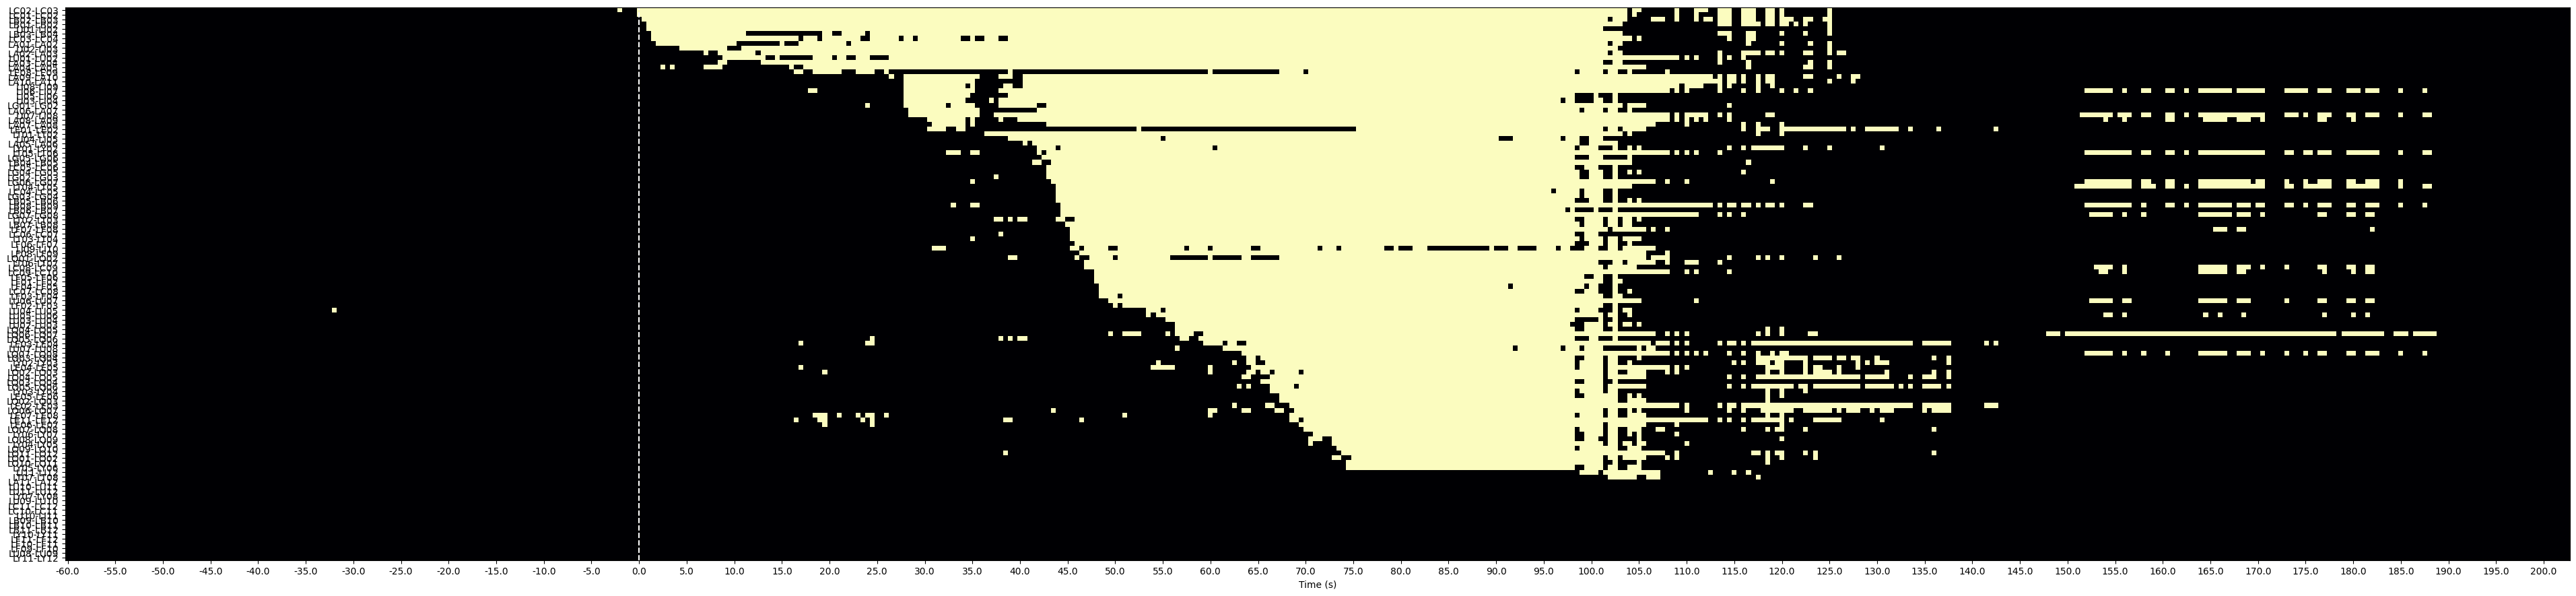

In [108]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_clf[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
# plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_vals.png'))

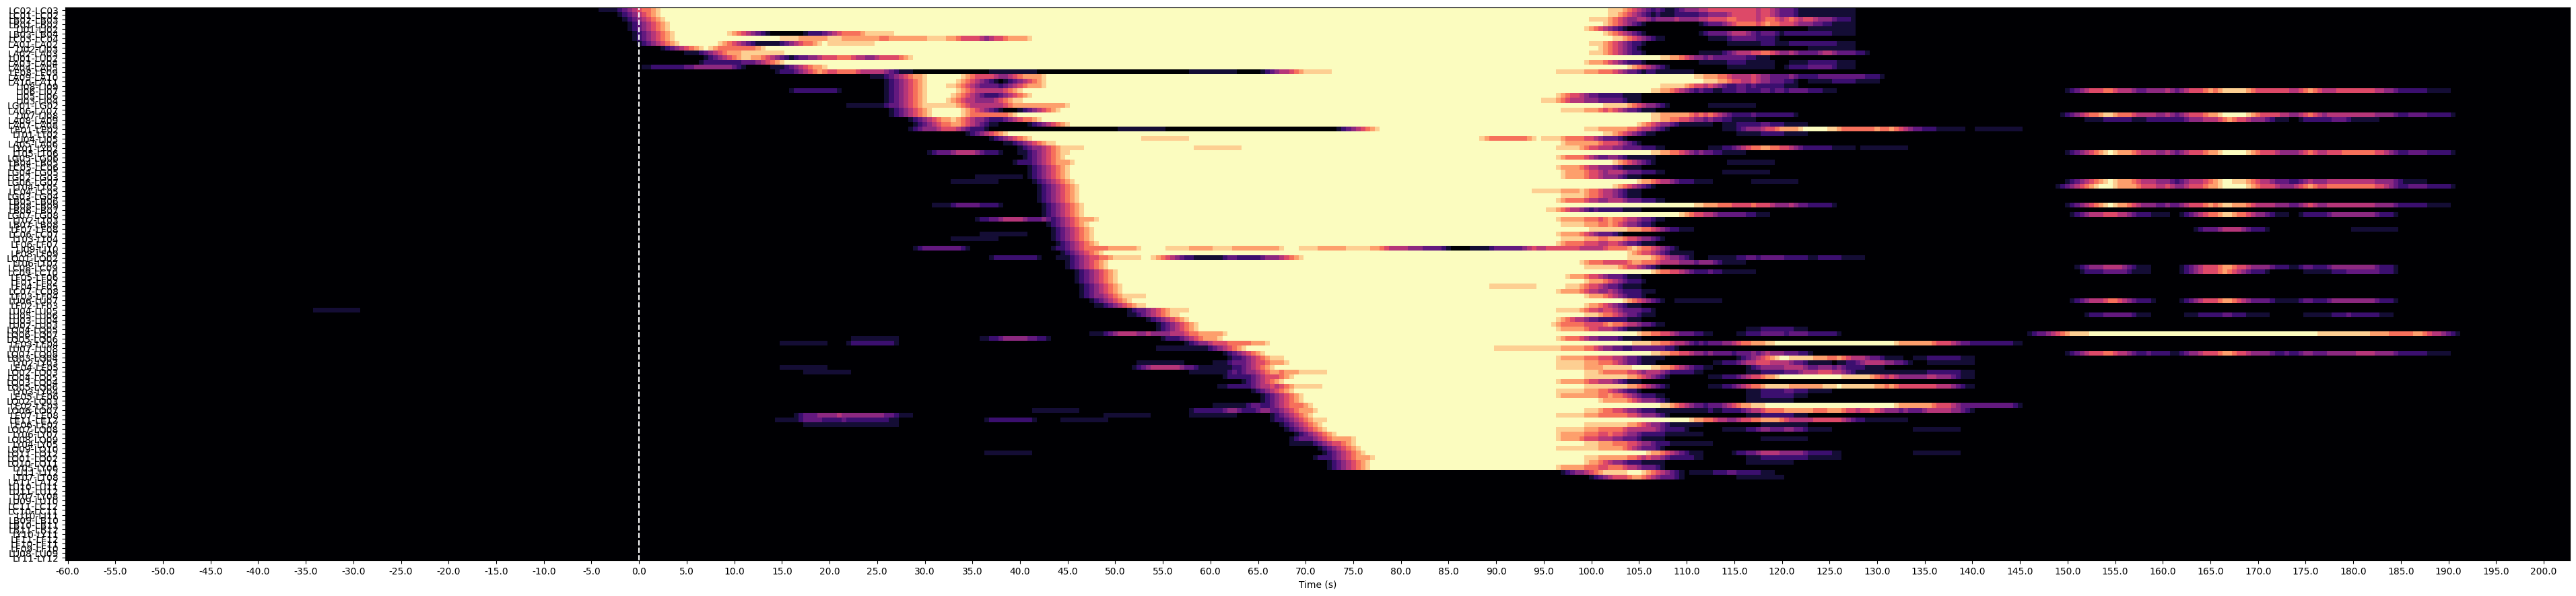

In [109]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_prob[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
# plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_prob.png'))

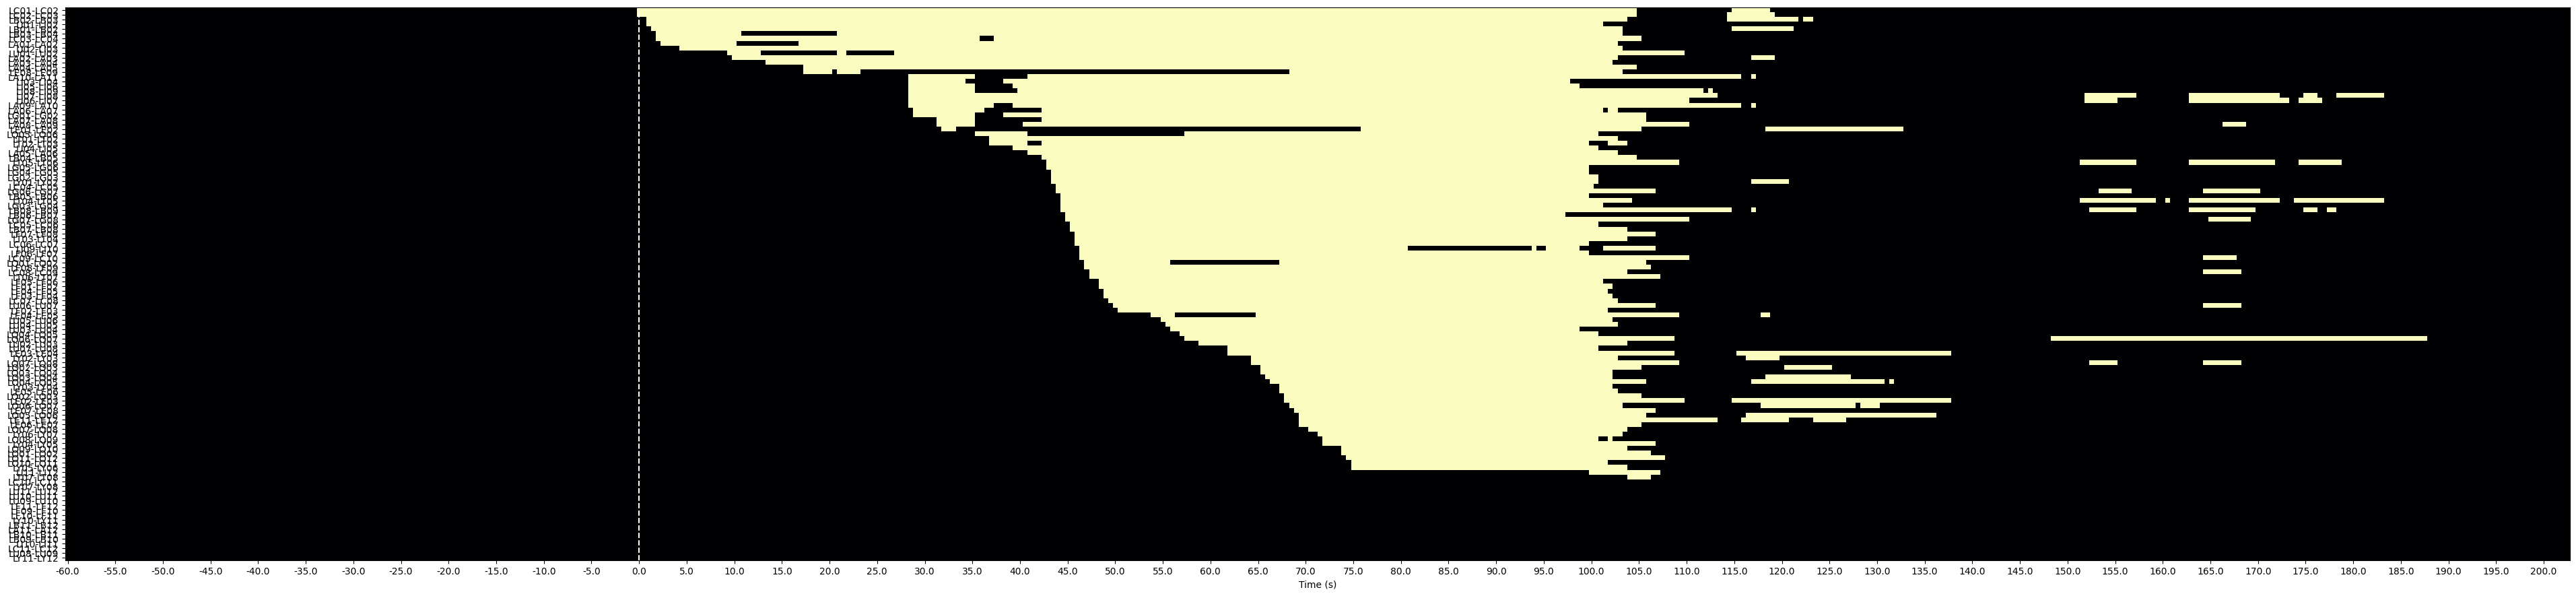

In [43]:
# Example threshold set to 0.6. Will find optimal threshold when we have 
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_prob[ch_sorting,:]>.5)
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
# plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_classification.png'))

### Generating UEO predictions

In [44]:
sz_clf_final = sz_prob > 0.5
first_seizing_index = np.argmax(sz_clf_final.any(axis=0))
mdl_ueo_idx = np.where(np.sum(sz_clf_final[:, first_seizing_index:first_seizing_index + 3], axis=1) > 0)[0]
mdl_ueo_ch_bp = seizure.columns.to_numpy()[mdl_ueo_idx]
mdl_ueo_ch = [s.split("-")[0] for s in mdl_ueo_ch_bp]
mdl_ueo_ch

['LB02', 'LC01', 'LC02', 'LI01']

### SVM predictions

In [82]:
sz_for_svm = np.percentile(seizure_mat,85,1)
all_ch_sz_pred = []
for i,m in enumerate(model_array):
    x_test = sz_for_svm[:,i].reshape(-1,1)
    all_ch_sz_pred.append(m.predict(x_test).reshape(-1,1))
all_ch_sz_pred_mat = np.concatenate(all_ch_sz_pred,1).T

In [83]:
all_ch_sz_pred_mat

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

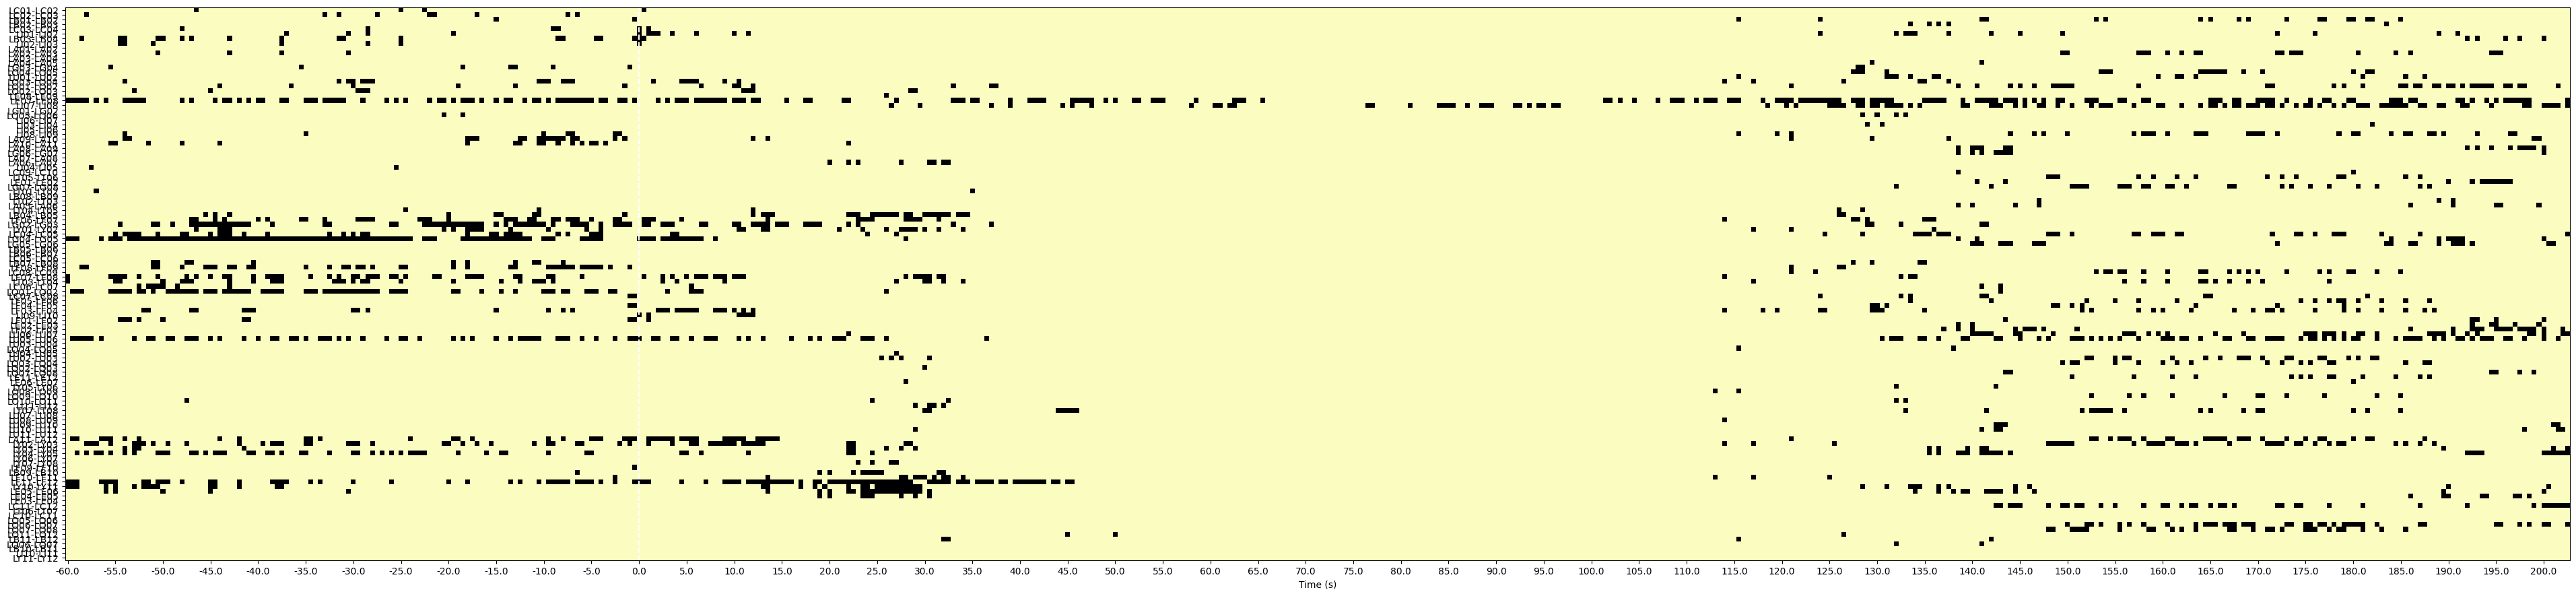

In [84]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(all_ch_sz_pred_mat == -1)
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10);
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60);

### Absolute slope null

In [104]:
scaler = RobustScaler().fit(inter)
ninter = scaler.transform(inter)
nseizure = scaler.transform(seizure)

In [105]:
base_stds = np.std(ninter,axis=0)
abs_slope = lambda x: np.mean(np.abs(np.diff(x,axis=-1)),axis=-1)
all_slopes = ft_extract(nseizure.T,fs,abs_slope,1,.5)
scaled_slopes = all_slopes.squeeze()/np.expand_dims(base_stds,1)*fs
# all_linlens = ft_extract(nseizure.T,fs,abs_slope,1,.5)/(0.5*fs)

In [106]:
# scaling linlen by the max value excluding outliers
all_linlens_norm = scale_normalized(scaled_slopes)
all_linlens_smoothed = sc.ndimage.uniform_filter1d(all_linlens_norm,10,axis=1)

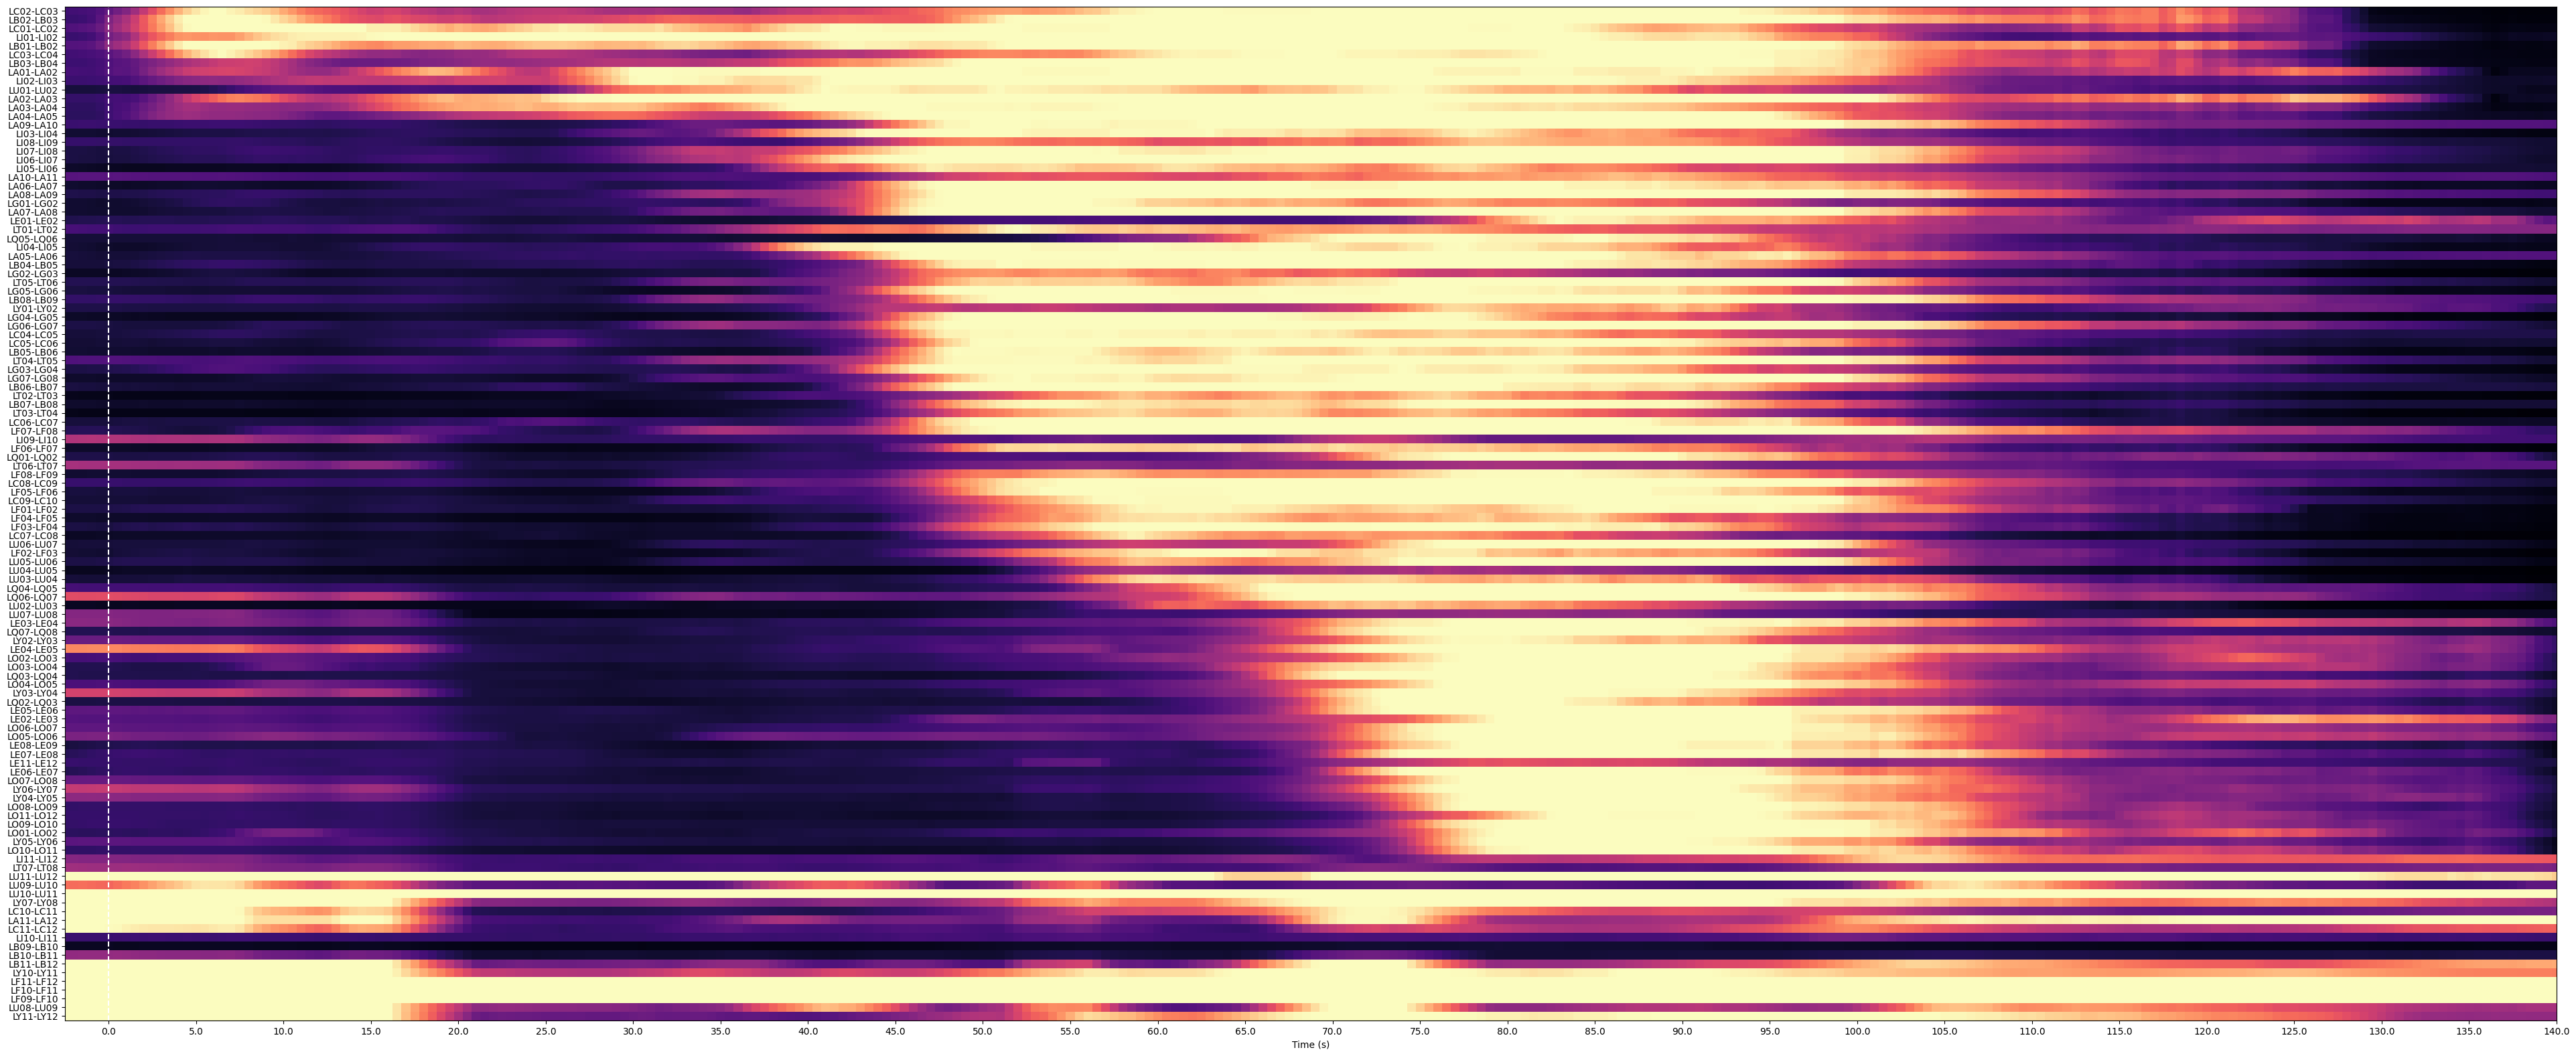

In [107]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(all_linlens_smoothed[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_null.png'))